# RNN & CTC

- RNN 모델과 CTC loss를 이용하여 오디오와 텍스트가 정렬이 안되어도 학습이 가능한 모델을 구현

In [1]:
import torch
import torchaudio  #feature extraction
import torch.nn as nn   # RNN module
import IPython.display as ipd
import matplotlib.pyplot as plt  #for visualization
%matplotlib inline

In [2]:
!wget https://github.com/dbstj1231/2023_AI_Academy_ASR/raw/main/set.wav

--2023-07-11 08:35:52--  https://github.com/dbstj1231/2023_AI_Academy_ASR/raw/main/set.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dbstj1231/2023_AI_Academy_ASR/main/set.wav [following]
--2023-07-11 08:35:52--  https://raw.githubusercontent.com/dbstj1231/2023_AI_Academy_ASR/main/set.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18998 (19K) [audio/wav]
Saving to: ‘set.wav’

set.wav             100%[===================>]  18.55K  --.-KB/s    in 0.001s  

2023-07-11 08:35:52 (15.2 MB/s) - ‘set.wav’ saved [18998/18998]



In [3]:
!ls

sample_data  set.wav


In [4]:
ipd.Audio("set.wav")

In [5]:
y,sr = torchaudio.load("set.wav")
y,sr

(tensor([[ 0.0000e+00,  6.1035e-05, -3.0518e-05,  ...,  3.0518e-05,
           1.2207e-04, -1.5259e-04]]),
 16000)

In [6]:
y.shape

torch.Size([1, 9424])

In [7]:
y.shape[1]/ sr

0.589

In [8]:
n_fft = 512
hop_length = n_fft // 2
n_mels = 64
sr = 16000

mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,
                                                     n_mels=n_mels,
                                                     sample_rate=sr,
                                                     hop_length=hop_length)

db_converter = torchaudio.transforms.AmplitudeToDB()

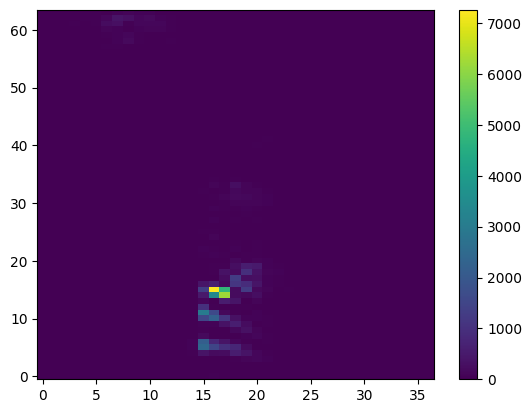

In [9]:
spec = mel_converter(y)
plt.imshow(spec[0],origin="lower",interpolation='nearest',aspect='auto')
plt.colorbar()

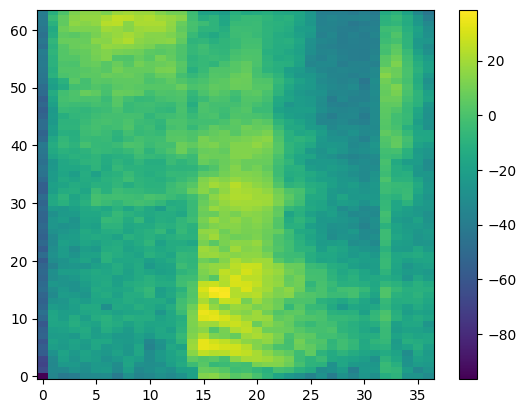

In [10]:
db_spec =db_converter(spec)
plt.imshow(db_spec[0],origin="lower",interpolation='nearest',aspect='auto')
plt.colorbar()

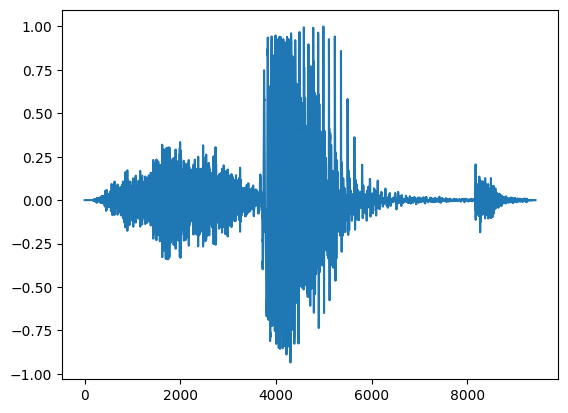

In [11]:
plt.plot(y[0])

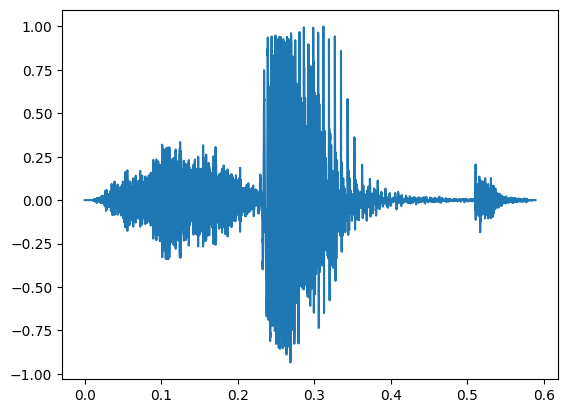

In [12]:
x = torch.arange(len(y[0]))/sr
plt.plot(x,y[0])

# gen character dict
```
'a' : 1 , 'b' : 2 , 'c':3 ... 'z':26
```

In [13]:
# gen character dict
# frame 10
# 1 - s
# 2 - s
# 3 - s
# 4~5 -e
# 6~9 t
#
#  sssss___eee___t  -> set
#  hello
#  hhhheeeelllllooo -> helo
#  hhhheeeell__looo -> hello

import string

char_set = dict(zip(string.ascii_lowercase, range(1,27)))
char_set['blk']=0

char_set


{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'blk': 0}

### torch.nn.RNN

- input: tensor of shape $(L,H_{in})$ for unbatched input, $(L,N,H_{in}​)$ when `batch_first=False` or $(N,L,H_{in}​)$ when batch_first=True containing the features of the input sequence. The input can also be a packed variable length sequence. See `torch.nn.utils.rnn.pack_padded_sequence()` or `torch.nn.utils.rnn.pack_sequence()` for details.

$$
\begin{aligned}
N =& \text{batch size} \\
L =& \text{sequence length} \\
H_{in} =& \text{input size} \\
\end{aligned}
$$



### arg of nn.RNN
>input_size: The number of expected features in the input `x`
>        
>hidden_size: The number of features in the hidden state `h`
>        
>num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
>            would mean stacking two RNNs together to form a `stacked RNN`,
>            with the second RNN taking in outputs of the first RNN and
>            computing the final results. Default: 1

In [14]:
class RNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.n_classes = 27 # # of char_set

    self.n_fft = 512
    self.n_mels = 64      # input_size of nn.RNN
    self.hop_length = self.n_fft // 2
    self.sr = 16000
    self.hidden_dim = 64
    self.n_char = 27

    self.mel_converter = torchaudio.transforms.MelSpectrogram(n_fft =self.n_fft,
                                                              n_mels = self.n_mels,
                                                              hop_length=self.hop_length,
                                                              sample_rate=self.sr
                                                              )
    self.db_converter  = torchaudio.transforms.AmplitudeToDB()


    # TODO:define rnn layer and output layer
    # input : n_mels hidden_dim = hidden_dim batch_first=True num_layer = 2
    self.rnn = nn.RNN(self.n_mels, self.hidden_dim, 2, batch_first=True)
    self.output_layer = nn.RNN(self.hidden_dim, self.n_char, 1, batch_first=True)

  def forward(self,x):
    # TODO: define forward
    # feature extraction
    # print(x.shape)

    x=self.mel_converter(x)
    x=self.db_converter(x)     # [1, n_mels, n_frames]

    # print(x.shape)


    x = x.transpose(1,2)  # [1, n_frames, n_mels]

    # print(x.shape)

    x, _ = self.rnn(x)

    # print(x.shape)

    x, _ = self.output_layer(x)
    # print(x.shape)

    # [a... blk] [  ]  [  ]
    x = torch.nn.functional.log_softmax(x, dim=-1)

    return x

model = RNNModel()

In [15]:
# check shape
# torch.Size([1, 9424])
# torch.Size([1, 64, 37])
# torch.Size([1, 37, 64])
# torch.Size([1, 37, 64])
# torch.Size([1, 37, 27])

out = model(y)
out.shape


torch.Size([1, 37, 27])

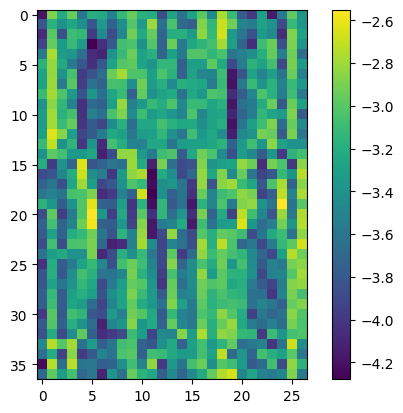

In [16]:
plt.imshow(out.cpu().detach().numpy()[0])
plt.colorbar()

In [17]:
# get char_list
char_list = sorted(char_set, key = lambda x: char_set[x])
char_list


['blk',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

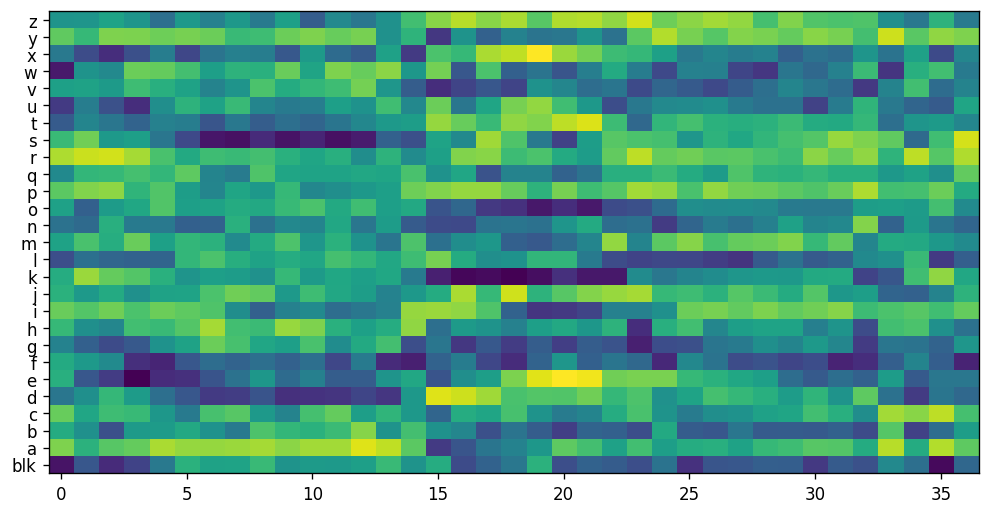

In [18]:
# show relation between time frame and character
plt.figure(figsize = (10,5), dpi = 120)
plt.imshow(out.cpu().detach().numpy().T, aspect='auto', interpolation='nearest', origin='lower')

ax = plt.gca()
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.show()

### CTCLoss
- 실제 출력(ground truth)과 모델이 예측한 출력 사이의 거리를 측정
- CTC는 각 입력 타임스텝에서 가능한 모든 경로를 고려하며, 각 경로의 확률을 합산하여 최종 예측을 생성

In [19]:
??nn.CTCLoss #target_len (3) input_len =(37) target , input

Object `nn.CTCLoss #target_len (3) input_len =(37) target , input` not found.


In [20]:
# check  "set" char_set and shape
torch.tensor([[char_set['s'], char_set['e'], char_set['t']]]).shape

torch.Size([1, 3])

  0%|          | 0/500 [00:00<?, ?it/s]

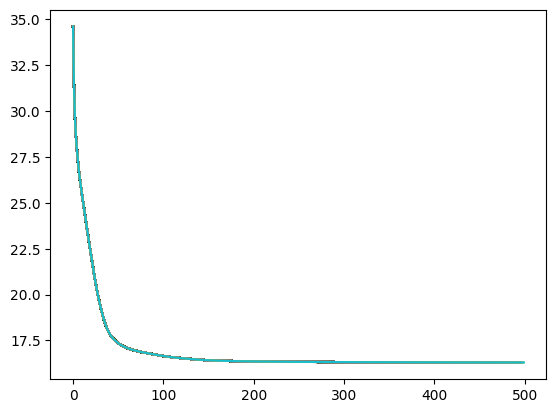

In [30]:
# define training loop

from tqdm.auto import tqdm

# device check
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RNNModel()
model.to(device)  # 7.11 수정사항

# epoch
num_epoch = 500

# CTCloss_fn , optimizer
ctc_loss = nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# input_length
input_lengths = torch.tensor(37)

# target, target_length
target =torch.tensor([[char_set['s'], char_set['e'], char_set['t']]], dtype=torch.int64)   # 7.11 수정사항
target_lengths = torch.tensor([[3]])

# batch data
y, sr = torchaudio.load("set.wav")
batch = [[y, target]]

# loss tracking
losses = []

#train loop
pbar = tqdm(range(num_epoch))
for e in pbar:
  for sample in batch:
    x, y = sample
    x = x.to(device)
    y = y.to(device)

    pred = model(x)  # [1, 37, 27]

    #loss
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)

    #loss tracking
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  plt.plot(losses)



In [31]:
# define plot_ctc
def plot_ctc(out, epoch):
  plt.figure(figsize=(8,4), dpi=100)
  plt.imshow(out.cpu().detach().numpy().T, aspect='auto', interpolation='nearest', origin='lower')
  plt.title(f"epoch: {epoch}")

  ax = plt.gca()
  ax.set_yticks(range(0,27))
  ax.set_yticklabels(char_list)

  plt.colorbar()
  plt.show()


  0%|          | 0/500 [00:00<?, ?it/s]

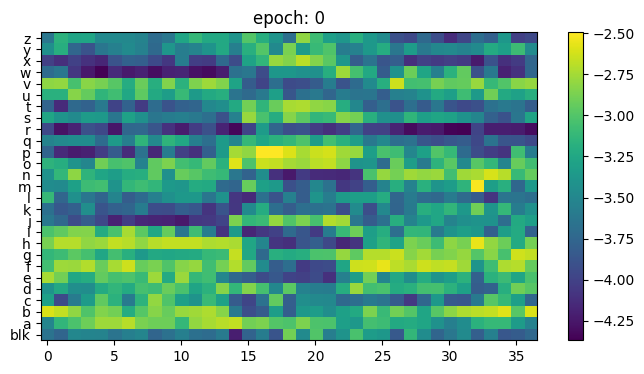

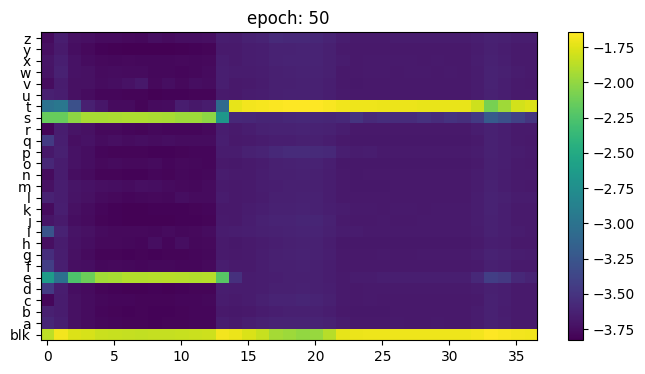

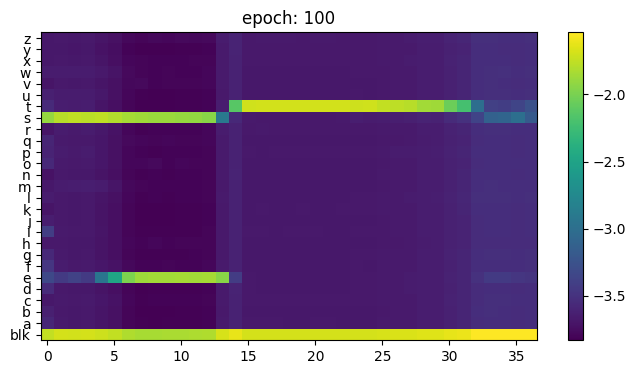

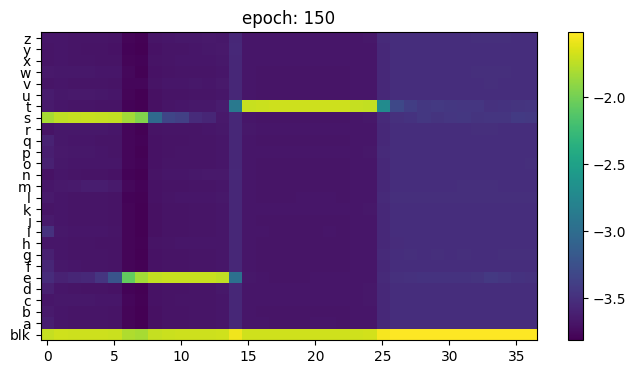

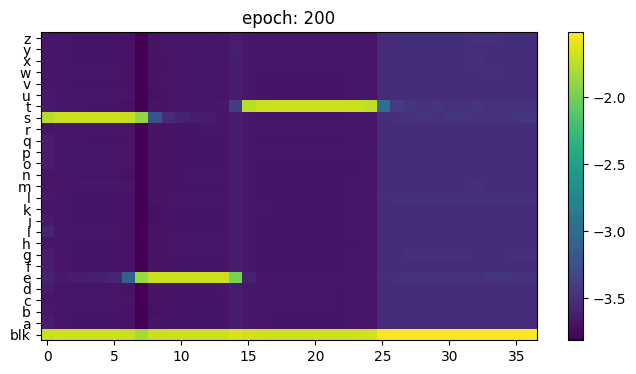

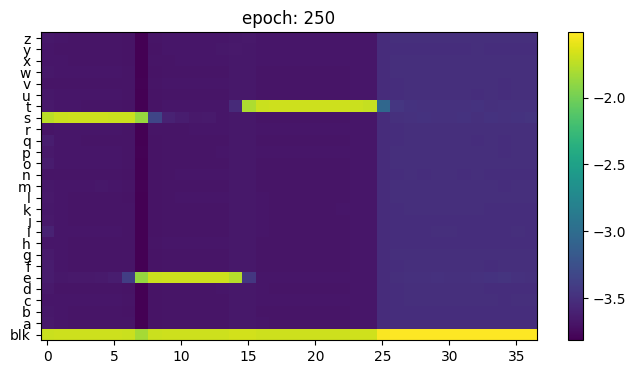

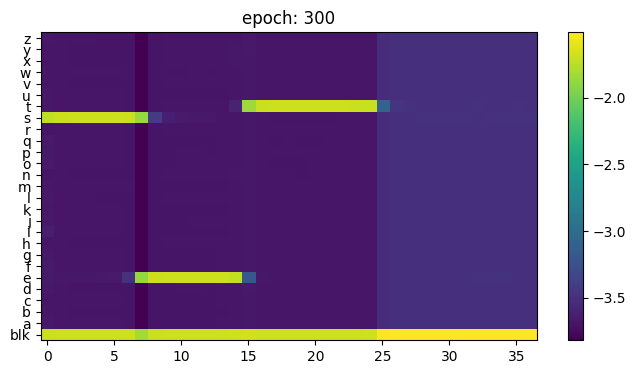

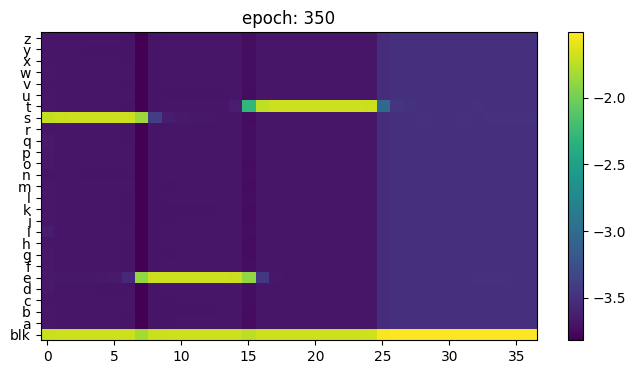

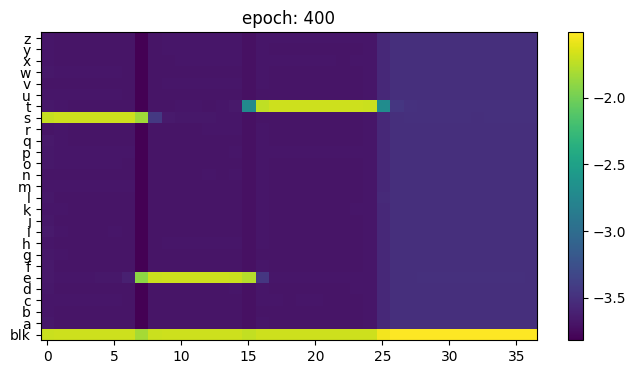

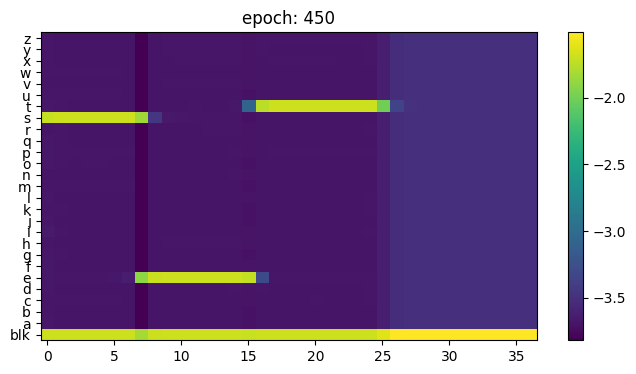

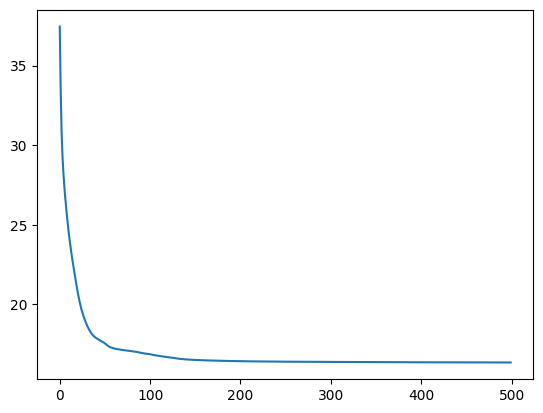

In [40]:
# define training loop

from tqdm.auto import tqdm

# device check
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RNNModel()
model.to(device)  # 7.11 수정사항

# epoch
num_epoch = 500

# CTCloss_fn , optimizer
ctc_loss = nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# input_length
input_lengths = torch.tensor(37)

# target, target_length
target =torch.tensor([[char_set['s'], char_set['e'], char_set['t']]], dtype=torch.int64)   # 7.11 수정사항
target_lengths = torch.tensor([[3]])

# batch data
y, sr = torchaudio.load("set.wav")
batch = [[y, target]]

# loss tracking
losses = []

#train loop
pbar = tqdm(range(num_epoch))
for e in pbar:
  for sample in batch:
    x, y = sample
    x = x.to(device)
    y = y.to(device)

    pred = model(x)  # [1, 37, 27]

    #loss
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)

    #loss tracking
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e % 50 ==0:
      plot_ctc(pred.cpu(), e)

plt.plot(losses)





In [41]:
# show output by plot_ctc

# 7.11 수정사항
y,sr = torchaudio.load("set.wav")
out = model(y.to(device))

visualization

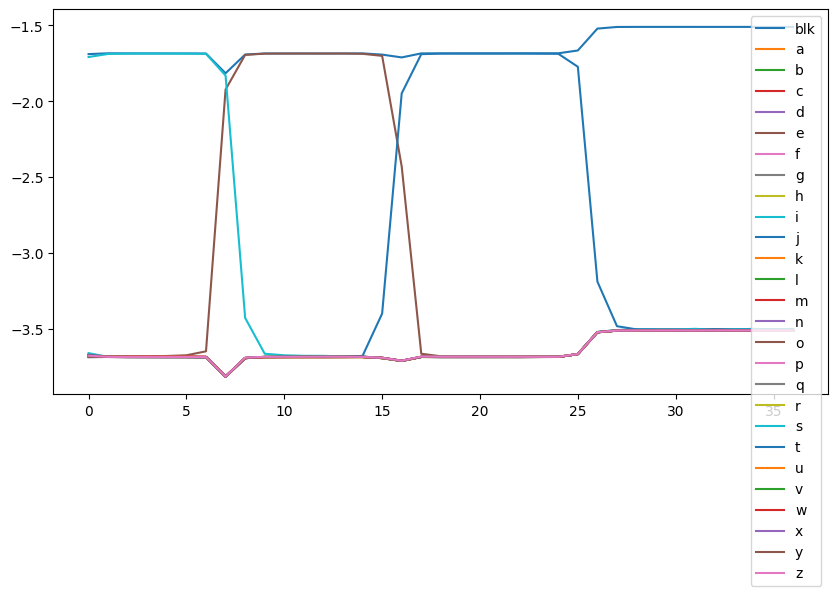

In [42]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(out[0].cpu().detach().numpy())
plt.legend(char_list)

plt.show()

In [43]:
??torch.exp

In [44]:
import plotly.graph_objects as go

data = torch.exp(out[0]).cpu().detach().numpy()
fig = go.Figure()
for idx, char_prob in enumerate(data.T):
  fig.add_trace(go.Line(y=char_prob, name=char_list[idx]))
fig.show()


## Q&A
```
Q : CTC에서 target에 있지 않은 blk의 확률값이 높은 이유는 무엇인가요
CTC에서 blk('_')는 shot pause, slience에 해당하는 확률이 될 수도 있고
apple, sorry 와 같이 같은 글자가 두번 나오는 경우에 pp_p, rr_r 과 같이 두 음을
구분하는 역할도 하게 되므로 확률이 높게 추정됩니다.


그래서 이를 해결하고자 나온 새로운 loss 가 Facebook의 wav2letter모델을 위해
제안한 auto segmentation criterion(ASG)가 있습니다.
다만 해당 criterion은 많이 사용되지는 않습니다.
```